# Data Setup

In [ ]:
!df -h /content

Filesystem      Size  Used Avail Use% Mounted on
overlay         236G   38G  199G  16% /


In [ ]:
!cp "/content/drive/MyDrive/Deep Learning/super-resolution-in-video-games/subset.zip" /content/

In [ ]:
!unzip -q /content/subset.zip -d /content/

# Imports & Installs

In [ ]:
!pip show torch

Name: torch
Version: 2.6.0+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchdata, torchvision


In [4]:
# General imports.
import os                        # Manipulate folders and files inside the operational system.
import gc                        # Python's garbage collector module - Still don't know if really needed.
import pandas as pd              # Tabular data manipulation library.
from tqdm.notebook import tqdm   # Progress bar in for loops.
from pathlib import Path         # Represent paths as classes.
import matplotlib.pyplot as plt  # Plotting library.

# Pytorch imports.
import torch                                                    # Base torch import.
import torch.nn as nn                                           # Neural network blocks for pytorch.
import torch.optim as optim                                     # Optimization module for pytorch.
from torch.utils.data import Dataset, DataLoader, random_split  # Base classes to create Pytorch datasets and dataloaders.
import torchvision.transforms as T                              # Pytorch transformations used on self.transform on Dataset.
import torch.nn.functional as F                                 # Pytorch functional module for the bicubic interpolation.
from torch.amp import autocast, GradScaler                      # Pytorch modules for training and gradient calculation.

# Visualization imports.
from PIL import Image  # Image rendering library.

# Variables, Functions and Classes Setup

## SRCNN


In [ ]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=5, padding=2),
        )

    def forward(self, x):
        return self.model(x)


## SRDataset Object

In [ ]:
class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.filenames = sorted(os.listdir(lr_dir))
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        lr_path = os.path.join(self.lr_dir, self.filenames[idx])
        hr_path = os.path.join(self.hr_dir, self.filenames[idx])

        lr = Image.open(lr_path).convert("RGB")
        hr = Image.open(hr_path).convert("RGB")

        if self.transform:
            lr = self.transform(lr)
            hr = self.transform(hr)

        return {"lr": lr, "hr": hr}


## Training & Validation/Eval Loop Functions

In [ ]:
scaler = GradScaler('cuda')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_epoch(model, dataloader, optimizer, device, epoch=0, print_every=10):
    model.train()
    running_loss = 0.0

    for i, batch in enumerate(dataloader):
        lr = batch["lr"].to(device)
        hr = batch["hr"].to(device)

        upscaled = F.interpolate(lr, size=hr.shape[-2:], mode='bicubic', align_corners=False)

        optimizer.zero_grad()

        with autocast('cuda'):
            output = model(upscaled)
            loss = F.mse_loss(output, hr)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        if i % print_every == 0:
            print(f"[Epoch {epoch+1}] Batch {i}/{len(dataloader)} - Loss: {loss.item():.6f}")

        gc.collect()
        torch.cuda.empty_cache()

    epoch_loss = running_loss / len(dataloader)
    print(f"[Epoch {epoch+1}] Final Loss: {epoch_loss:.6f}")
    return epoch_loss

In [ ]:
@torch.no_grad()
def evaluate_one_epoch(model, dataloader, device):
    model.eval()
    val_loss = 0.0

    for batch in dataloader:
        lr = batch["lr"].to(device)
        hr = batch["hr"].to(device)
        upscaled = F.interpolate(lr, size=hr.shape[-2:], mode='bicubic', align_corners=False)
        output = model(upscaled)
        loss = F.mse_loss(output, hr)
        val_loss += loss.item()

    return val_loss / len(dataloader)

# Execution

## Viewing a simple image and some statistics

In [ ]:
# Trying to allocate all in memory (test)
lr_sample_path = "/content/subset/train/lr"
hr_sample_path = "/content/subset/train/hr"

image_idx = 50  # Some good images: 50, 60
lr_img_name = sorted(os.listdir(lr_sample_path))[image_idx]
hr_img_name = sorted(os.listdir(hr_sample_path))[image_idx]

lr_img_path = os.path.join(lr_sample_path, lr_img_name)
hr_img_path = os.path.join(hr_sample_path, hr_img_name)

lr_img = Image.open(lr_img_path)
hr_img = Image.open(hr_img_path)

print(f"LR ({lr_img_name}): {lr_img.size}")
print(f"HR ({hr_img_name}): {hr_img.size}")

to_tensor = T.ToTensor()
lr_tensor = to_tensor(lr_img)
hr_tensor = to_tensor(hr_img)

def tensor_mem_mb(t: torch.Tensor):
    return t.numel() * t.element_size() / (1024 ** 2)

print(f"LR tensor shape: {lr_tensor.shape}, memory: {tensor_mem_mb(lr_tensor):.2f} MB")
print(f"HR tensor shape: {hr_tensor.shape}, memory: {tensor_mem_mb(hr_tensor):.2f} MB")

print(f"If we were to allocate all in memory: {(tensor_mem_mb(lr_tensor) + tensor_mem_mb(hr_tensor)) * 5000 / 1024:.2f} GB")

LR (00207.png): (480, 270)
HR (00207.png): (1920, 1080)
LR tensor shape: torch.Size([4, 270, 480]), memory: 1.98 MB
HR tensor shape: torch.Size([4, 1080, 1920]), memory: 31.64 MB
If we were to allocate all in memory: 164.15 GB


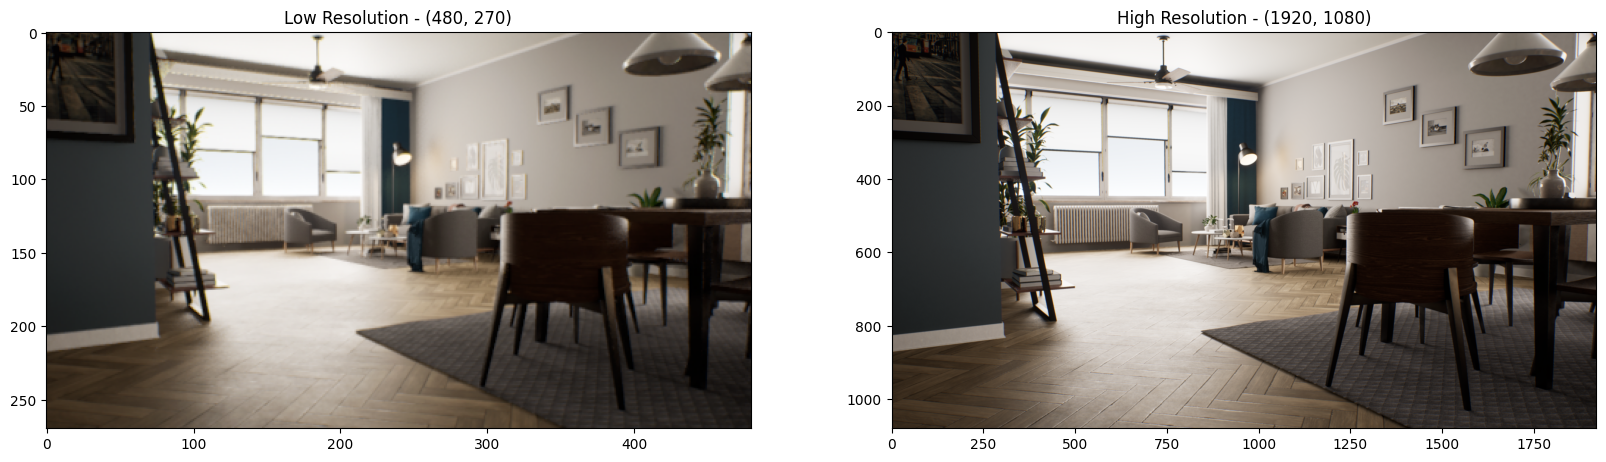

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(lr_img)
axs[0].set_title(f"Low Resolution - {lr_img.size}")
axs[1].imshow(hr_img)
axs[1].set_title(f"High Resolution - {hr_img.size}")
plt.show()

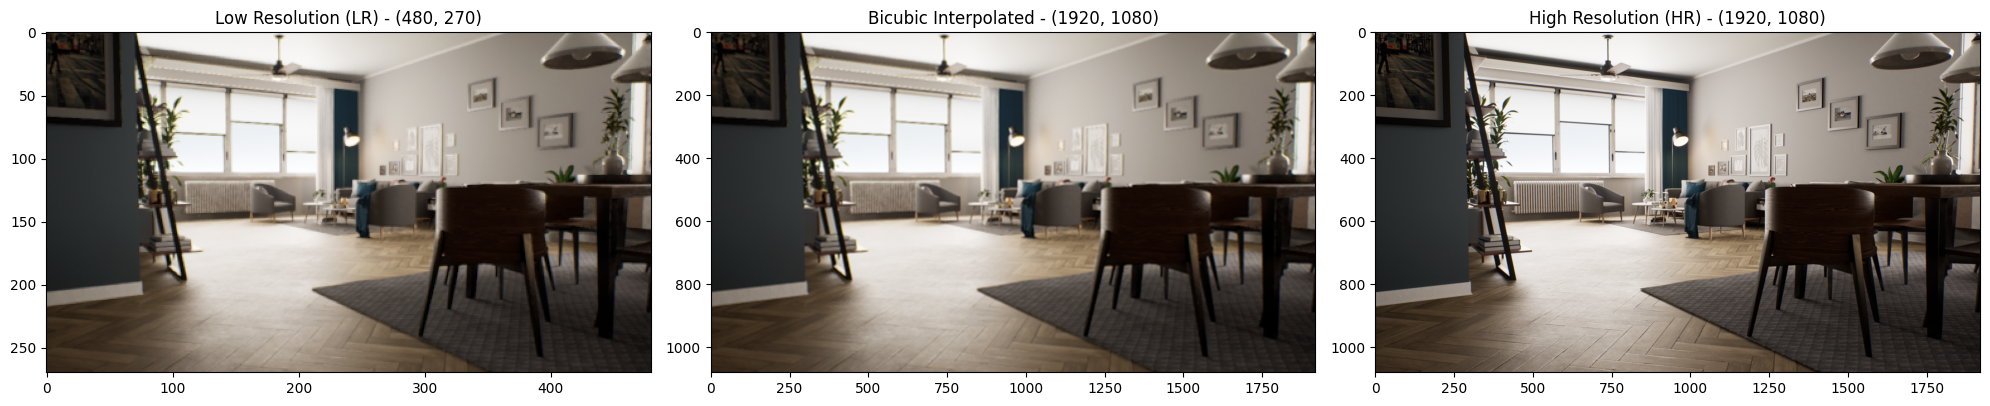

In [ ]:
import torchvision.transforms.functional as TF

lr_tensor_batched = lr_tensor.unsqueeze(0)

upscaled_tensor = F.interpolate(lr_tensor_batched, size=hr_tensor.shape[-2:], mode='bicubic', align_corners=False)
upscaled_tensor.clamp(0, 1).shape

fig, axs = plt.subplots(1, 3, figsize=(20, 10))

axs[0].imshow(lr_img)
axs[0].set_title(f"Low Resolution (LR) - {lr_img.size}")

bicubic_img = TF.to_pil_image(upscaled_tensor.clamp(0, 1).squeeze(0))
axs[1].imshow(bicubic_img)
axs[1].set_title(f"Bicubic Interpolated - {bicubic_img.size}")

axs[2].imshow(hr_img)
axs[2].set_title(f"High Resolution (HR) - {hr_img.size}")

plt.tight_layout()
plt.show();

## Create Dataset and DataLoader objects

In [ ]:
transform = T.ToTensor()

full_dataset = SRDataset(
    lr_dir="/content/subset/train/lr",
    hr_dir="/content/subset/train/hr",
    transform=transform,
)

BATCH_SIZE=4
NUM_WORKERS=2
VAL_SPLIT_PERCENTAGE = 0.8

train_size = int(VAL_SPLIT_PERCENTAGE*len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True,
)

In [ ]:
model = SRCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
val_losses = []
best_val_loss = float("inf")

EPOCHS = 10

for epoch in range(EPOCHS):

    train_loss = train_one_epoch(model, train_loader, optimizer, device, epoch=epoch, print_every=200)
    val_loss = evaluate_one_epoch(model, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss:.6f}. Val Loss: {val_loss:.6f}.")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/best_srcnn.pth")


[Epoch 1] Batch 0/800 - Loss: 0.122912
[Epoch 1] Batch 200/800 - Loss: 0.007263
[Epoch 1] Batch 400/800 - Loss: 0.006497
[Epoch 1] Batch 600/800 - Loss: 0.005004
[Epoch 1] Final Loss: 0.007180
[Epoch 1/10] Train Loss: 0.007180. Val Loss: 0.005115.
[Epoch 2] Batch 0/800 - Loss: 0.003546
[Epoch 2] Batch 200/800 - Loss: 0.002576
[Epoch 2] Batch 400/800 - Loss: 0.003607
[Epoch 2] Batch 600/800 - Loss: 0.008615
[Epoch 2] Final Loss: 0.004989
[Epoch 2/10] Train Loss: 0.004989. Val Loss: 0.005109.
[Epoch 3] Batch 0/800 - Loss: 0.004792
[Epoch 3] Batch 200/800 - Loss: 0.005587
[Epoch 3] Batch 400/800 - Loss: 0.002797
[Epoch 3] Batch 600/800 - Loss: 0.005507
[Epoch 3] Final Loss: 0.004932
[Epoch 3/10] Train Loss: 0.004932. Val Loss: 0.005190.
[Epoch 4] Batch 0/800 - Loss: 0.006033
[Epoch 4] Batch 200/800 - Loss: 0.006361
[Epoch 4] Batch 400/800 - Loss: 0.004613
[Epoch 4] Batch 600/800 - Loss: 0.005094
[Epoch 4] Final Loss: 0.004870
[Epoch 4/10] Train Loss: 0.004870. Val Loss: 0.005082.
[Epoch 5

# Post Processing and Saving Data

In [3]:
# Save the DataFrame with the train and validation losses for each epoch:

# loss_df = pd.DataFrame({
#     "epoch": list(range(1, EPOCHS + 1)),
#     "train_loss": train_losses,
#     "val_loss": val_losses
# })
# loss_df.to_csv("/content/drive/MyDrive/loss_history.csv", index=False)

# Import the saved DataFrame:

df = pd.read_csv("/content/drive/MyDrive/Deep Learning/SRCNN/loss_history.csv")
df.head(10)

,epoch,train_loss,val_loss
0,1,0.007180,0.005115
1,2,0.004989,0.005109
2,3,0.004932,0.005190
3,4,0.004870,0.005082
4,5,0.004875,0.005055
5,6,0.004859,0.004973
6,7,0.004834,0.004967
7,8,0.004814,0.005119
8,9,0.004783,0.004889
9,10,0.004806,0.004862


## Training and Validation Curves

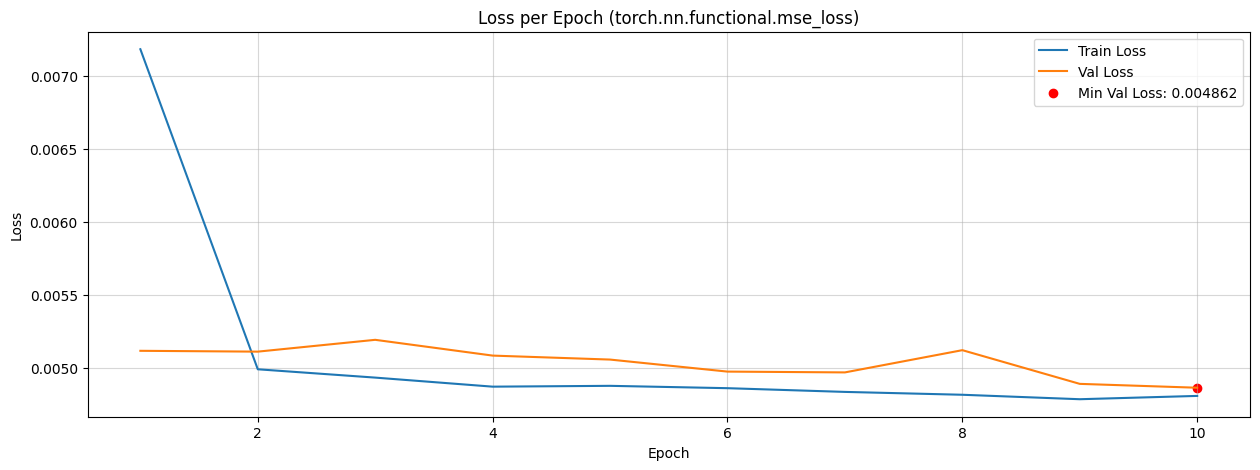

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

min_loss = df['val_loss'].min()
min_epoch = df.loc[df['val_loss'].idxmin(), 'epoch']

ax.plot(df['epoch'], df['train_loss'], label='Train Loss')
ax.plot(df['epoch'], df['val_loss'], label='Val Loss')
ax.scatter(min_epoch, min_loss, color='red', label=f'Min Val Loss: {min_loss:.6f}')

ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss per Epoch (torch.nn.functional.mse_loss)')
ax.grid(alpha=0.5)